# Exploration of the Airbnb dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("poster")

# Cleaning the train_users table

In [2]:
train_users = pd.read_csv('csvdata/train_users_2.csv')
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
# clean up the timestamps in the train_users dataframe 

train_users.timestamp_first_active = pd.to_datetime(train_users.timestamp_first_active.astype(str))
train_users.date_first_booking = pd.to_datetime(train_users.date_first_booking)
train_users.date_account_created = pd.to_datetime(train_users.date_account_created)

train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
len(train_users.id.unique()) == len(train_users)

True

<div class='alert alert-info'>

No users are repeated in the `train_users` table. 

</div>

In [5]:
train_users.describe()

,age,signup_flow
count,125461.000000,213451.000000
mean,49.668335,3.267387
std,155.666612,7.637707
min,1.000000,0.000000
25%,28.000000,0.000000
50%,34.000000,0.000000
75%,43.000000,0.000000
max,2014.000000,25.000000


<div class='alert alert-info'>

`age` is the only numerical feature. We see that there are some bad values for `age`, as evidenced by the maximum and the standard deviation in the table above. `signup_flow` is the page number from which the user signed up. We will convert it into a categorical feature later. 

</div>

In [6]:
train_users.age[train_users.age>=200].describe()

count     779.000000
mean     2011.097561
std        14.718288
min      1924.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

<div class='alert alert-info'>
For `age` values above `200`, the values start at `1924` and end at `2014`. These may either be birth years or data collection years - users born in `2014` are too young to make a booking. This indicates an inconsistency with integrating the data from different sources into one database. That so many users record birth year as 2014 is an indication that the default age on the forms on some app or browser is the current year, rather than non-numerical. 
</div>

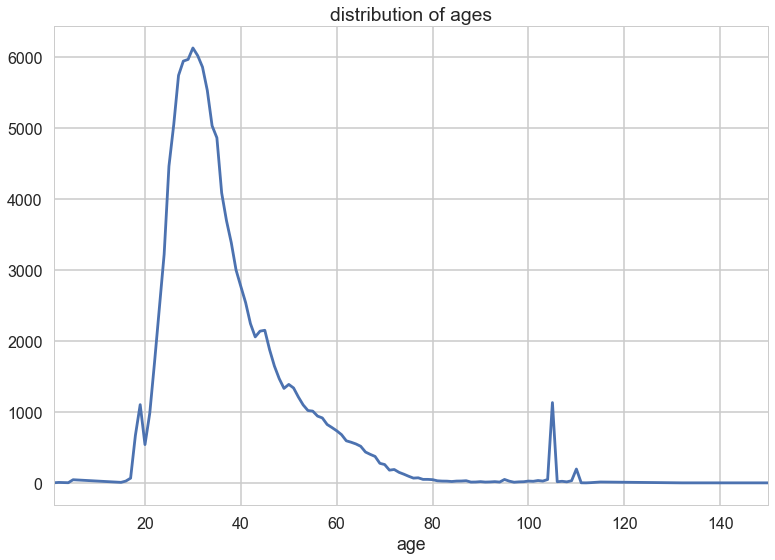

In [7]:
# Get rid of age values bigger than 200 and plot the age distribution 

train_users.age[train_users.age < 200].value_counts().sort_index().plot()
plt.title('distribution of ages')
plt.xlabel('age')
None

<div class='alert alert-info'>

<p> We observe that there is an unexpected spike in ages between 100 and 120. We will remove those age values. Also, some values in the age column are years such as 1949 or 2014. These values will also be removed. Perhaps this indicates non-sanitized forms, or that forms are collecting the data in incompatible ways depending on the platform - such as one form collecting age and another collecting birth dates.</p> 

<p>**Action item**: implement a drop-down menu rather than a text field for `age`. </p>

</div>

In [8]:
# clear out the suspiciously large age values

mean_age = train_users.age.loc[(train_users.age < 100)].mean()
train_users.age.loc[(train_users.age > 100)] = np.nan

# calculate the age buckets and add them to the train_users table 

def calc_age_bucket(age):
    '''
    this function calculates five year age buckets, given the age
    '''
    if age < 100.0:
        return (age // 5.0) + 1
    elif age >= 100.0:
        return 21.0
    elif np.isnan(age):
        return 0.0

train_users['age_bucket'] = train_users.age.apply(calc_age_bucket).astype('category')


/Users/partha/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Missing data

In [9]:
# how many missing values in each column

train_users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         90335
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
age_bucket                      0
dtype: int64

<div class='alert alert-info'>

<p>There are a number of missing values, for `date_first_booking`, `age` and `first_affiliate_tracked`. It turns out that the missing `date_first_booking` values are exactly the users who made no booking. Missing `age` values are missing because some people choose not to divulge their age. Why are `first_affiliate_tracked` values missing?</p>

<p><b>Action item</b>: Check whether something strange is happening with the data collection.</p>

</div>

In [10]:
# percentage of users for whom age and gender information is available/unavailable

t = train_users.groupby([(train_users.gender != '-unknown-'), (train_users.age.notnull())]).size().unstack()
100. * t / float(t.values.sum())

age,False,True
gender,,
False,37.268038,7.560986
True,5.053150,50.117826


<div class='alert alert-info'>

<p>We see that 50% of the users choose to inform us about their age and their gender, while 37% of the users choose not to inform us about their age and their gender. Let us see what percentage of each of these groups make a booking:</p>

</div>

In [11]:
# conversion rate of users for whom age and gender information is available/unavailable

s = train_users.groupby([(train_users.gender != '-unknown-'), 
                         (train_users.age.notnull()), 
                         train_users.date_first_booking.notnull()]).size().unstack().astype(float)
s = s[True] / (s[True]+s[False])
s = s.unstack()
100. * s

age,False,True
gender,,
False,21.976392,71.479026
True,39.078435,52.043897


<div class='alert alert-info'>

<p>We see that among the users who choose to inform us about their age and their gender, 52% make a booking, while only 22% of the users who choose not to inform us about their age and their gender make a booking. The users who do not give out age and gender information are likely very concerned about privacy issues. </p>

<p><b>Action item</b>: Include a friendly reassurance about protecting their privacy to the users who choose not to inform us about their age or their gender. </p>

</div>

In [12]:
# fill in the missing age values

train_users.age.loc[train_users.age.isnull()] = mean_age
train_users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                             0
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
age_bucket                      0
dtype: int64

In [13]:
# only keep the users for whom date_account_created matches timestamp_first_active. 
# the users for whom the dates do not match likely represent bad data or early adoption data. 
# such users are very small in number, and no such users appear in the test data. 

train_users = train_users[train_users.timestamp_first_active.dt.date == train_users.date_account_created.dt.date]

In [14]:
# separate the date_first_booking column as a column of 1/0
# drop all the date_first_booking values - they're not present in the test_users table. 

y_users = train_users.date_first_booking.notnull().astype(int)

#train_users = train_users.drop('date_first_booking', axis=1)

In [15]:
s = train_users.country_destination.value_counts()
s = s * 100. / float(s.values.sum())
s

NDF      58.370727
US       29.205291
other     4.728681
FR        2.353322
IT        1.327407
GB        1.086401
ES        1.053110
CA        0.668158
DE        0.496078
NL        0.356820
AU        0.252259
PT        0.101748
Name: country_destination, dtype: float64

<div class='alert alert-info'>

<p>Roughly 58% of the users do not book, roughly 29% of the users make their first booking within the USA and roughly 13% of the users make their first booking in another country.  </p>

</div>

In [16]:
np.array_equal((train_users.country_destination != 'NDF'), y_users)

True

<div class='alert alert-info'>

<p>The users for whom the destination is not found are exactly the same as the users for whom the date of first booking is missing. </p>

</div>

In [17]:
# create features: year, month and dayofweek from date_account_created. 

train_users.loc[:,'year'] = train_users.date_account_created.dt.year.astype('category')
train_users.loc[:,'quarter'] = train_users.date_account_created.dt.quarter.astype('category')
train_users.loc[:,'month'] = train_users.date_account_created.dt.month.astype('category')
train_users.loc[:,'dayofweek'] = train_users.date_account_created.dt.dayofweek.astype('category')
train_users.loc[:,'hour'] = train_users.timestamp_first_active.dt.hour.astype('category')

# mark a the following columns as categorical data
mylist = ['gender', 'signup_method', 'language', 'affiliate_channel', 
          'affiliate_provider', 'first_affiliate_tracked', 'signup_flow', 
          'signup_app', 'first_device_type', 'first_browser']
for x in mylist:
    train_users.loc[:,x] = train_users[x].astype('category')

# only keep the users from 2014 for now - the test set only involves the users from 2014 
# train_users = train_users[(train_users.year == 2014)]

# Conversion Rate and Traffic Analysis

<div class='alert alert-info'>

<p>By `conversion rate`, we mean the percentage (or proportion) of users who make a booking. By `traffic` we mean the number of users. </p>

</div>

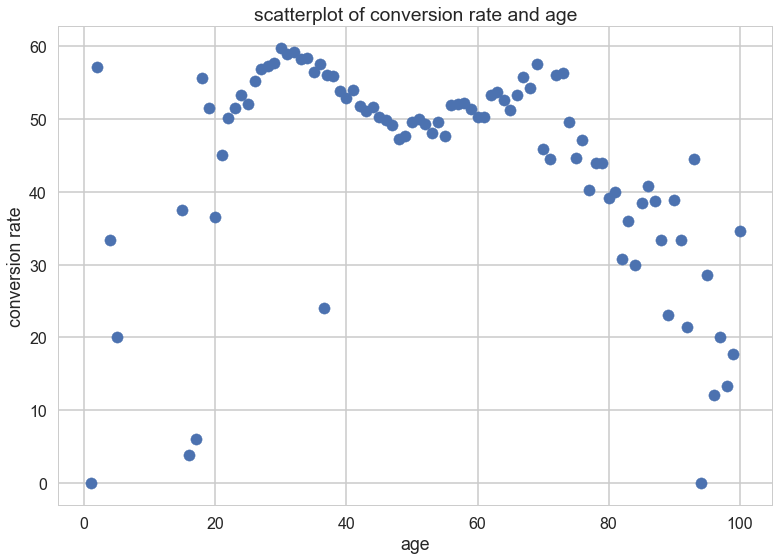

In [18]:
ndf = train_users.groupby(['age', 'country_destination']).size().unstack().NDF
total = train_users.groupby(['age']).size()
s = 100.0 - 100.0 * ndf / total
plt.scatter(s.index, s.values)
plt.xlabel('age')
plt.ylabel('conversion rate')
plt.title('scatterplot of conversion rate and age')
None

<div class='alert alert-info'>

<p>We see a notable drop in late 30's which corresponds to the missing age values. They appear in late 30's because we artificially set those values to the mean age. This observation also reinforces our previous observation regarding low conversion rate among those who choose not to disclose their age.</p>

<p>We see two notable peaks: one for young adults of age ~30 and another for recently retired people aged 65-70. It would be profitable to increase the charges for these people or to offer them less discounts and promotions.</p>

</div>

In [19]:
def plot_conversion_rate(column_name, kind='bar',st=None):
    '''this function calculates and plots the conversion rate according to column_name'''
    ndf = train_users.groupby([column_name, 'country_destination']).size().unstack().NDF
    ndf.name = 'frequency'
    total = train_users.groupby([column_name]).size()
    contingency = pd.DataFrame(ndf).join(pd.DataFrame(total-ndf))
    print 'chi2 statistic for the conversion rate:', chi2_contingency(contingency)[0]
    print 'p-value for the conversion rate:', chi2_contingency(contingency)[1]
    s = 100.0 - 100.0 * ndf / total 
#     s.sort_values(ascending=False).plot(kind=kind, figsize=(8,6))
#     plt.title('conversion rate (percent)')
#     plt.ylabel('percent converted')
#     plt.xlabel(column_name)

    total_filtered = total[total / float(total.values.sum()) > 0.05].copy().astype(float)
    total_filtered.index = list(total_filtered.index)
    total_filtered.at['other'] = float(total[total / float(total.values.sum()) < 0.05].sum())
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,8))
    s.sort_values(ascending=False)[:20].plot(kind=kind, ax=ax0, alpha=0.8)
    ax0.set_ylim(bottom=0)
    ax0.set_xlabel(column_name)
    ax0.set_ylabel('percent converted')
    ax0.set_title('conversion rate (percent)')
    col=['powderblue', 'goldenrod', 'rosybrown', 'thistle','violet']
    ax1.pie(total_filtered.values, labels=total_filtered.index, autopct='%1.f%%', colors=col, startangle=st)
    ax1.set_title('traffic frequency for\n' + column_name)
    fig.tight_layout()

    df = pd.DataFrame([total, s], index=['traffic_freqency', 'conversion_rate']).sort_values('conversion_rate', ascending=False, axis=1)
    return df.dropna(axis=1)

chi2 statistic for the conversion rate: 277.665718547
p-value for the conversion rate: 5.07756288466e-61


signup_method,basic,facebook,google
traffic_freqency,152775.000000,59952.000000,546.000000
conversion_rate,42.527901,39.549973,18.498168


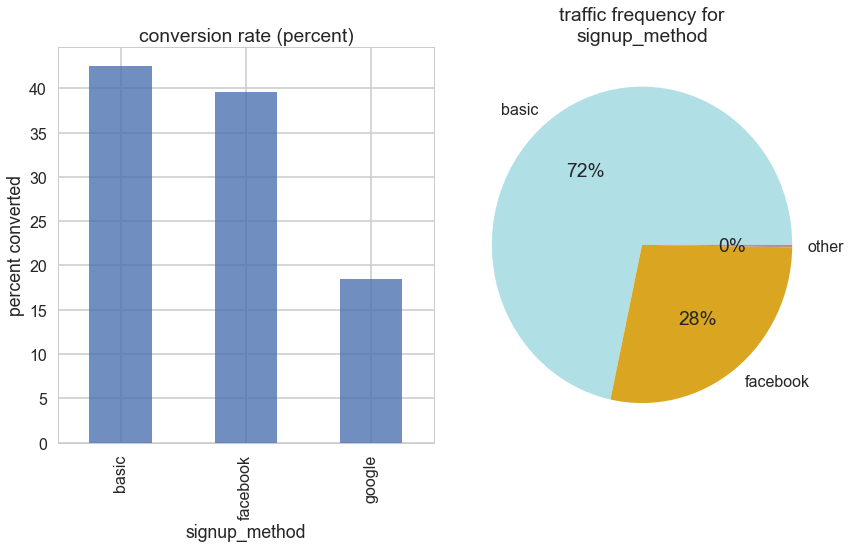

In [20]:
plot_conversion_rate('signup_method')

<div class='alert alert-info'>

<p>Those who signup with Google have half the conversion rate compared to those who signup directly or with Facebook. The success of Facebook compared to Google may be because of the social proof of endorsement by friends.</p> 

<p><b>Action item</b>: Implement extraneous social proof of endorsement for the users who signup with Google.</p>

</div>

chi2 statistic for the conversion rate: 9154.76667588
p-value for the conversion rate: 0.0


gender,OTHER,MALE,FEMALE,-unknown-
traffic_freqency,280.000000,54373.000000,62964.000000,95656.000000
conversion_rate,62.142857,50.902102,50.721047,30.313833


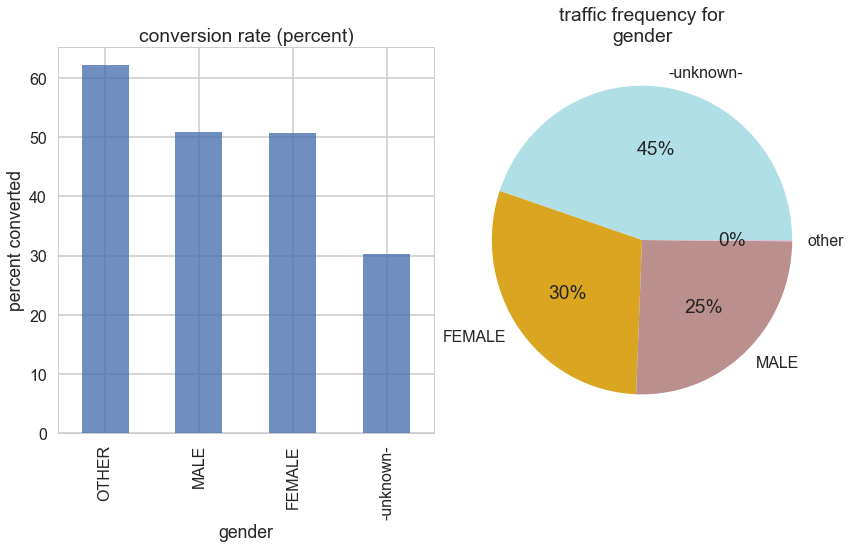

In [21]:
plot_conversion_rate('gender')

<div class='alert alert-info'>

No difference between the conversion rates of Males and Females. Perhaps those who refuse to disclose their gender are very likely concerned about privacy. It may be a good idea to reassure them about protecting their privacy. Only a very small number of users self-identify as Other gender and it appears that Airbnb is treating them well, as evidenced by the conversion rates. 

</div>

chi2 statistic for the conversion rate: 1756.05295997
p-value for the conversion rate: 0.0


affiliate_channel,seo,direct,sem-brand,other,sem-non-brand,api,remarketing,content
traffic_freqency,8656.00000,137599.000000,26027.000000,8953.000000,18841.000000,8155.000000,1096.000000,3946.00000
conversion_rate,45.64464,43.100604,42.582703,40.165308,37.943846,34.015941,33.576642,14.11556


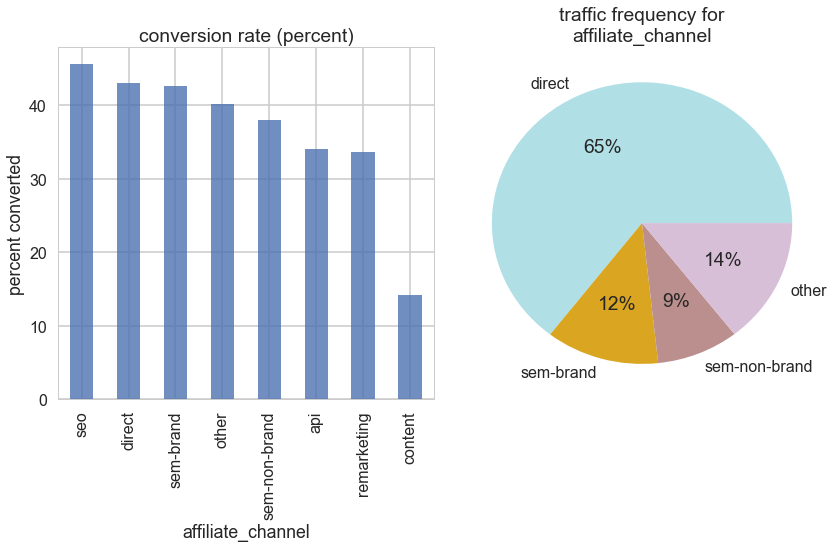

In [22]:
plot_conversion_rate('affiliate_channel')

<div class='alert alert-info'>

<p>The affiliate channel 'content' seems to be significantly worse compared to all the other channels. </p>
<p><b>Action item</b>: Investigate what's going on with the `affiliate_channel` named `content`.</p>

</div>

chi2 statistic for the conversion rate: 652.222704989
p-value for the conversion rate: 1.25893823039e-137


first_affiliate_tracked,marketing,untracked,linked,omg,tracked-other,product,local ops
traffic_freqency,139.000000,109133.000000,46249.000000,43952.000000,6151.000000,1554.000000,34.000000
conversion_rate,45.323741,43.678814,43.399857,37.331635,37.180946,34.813385,26.470588


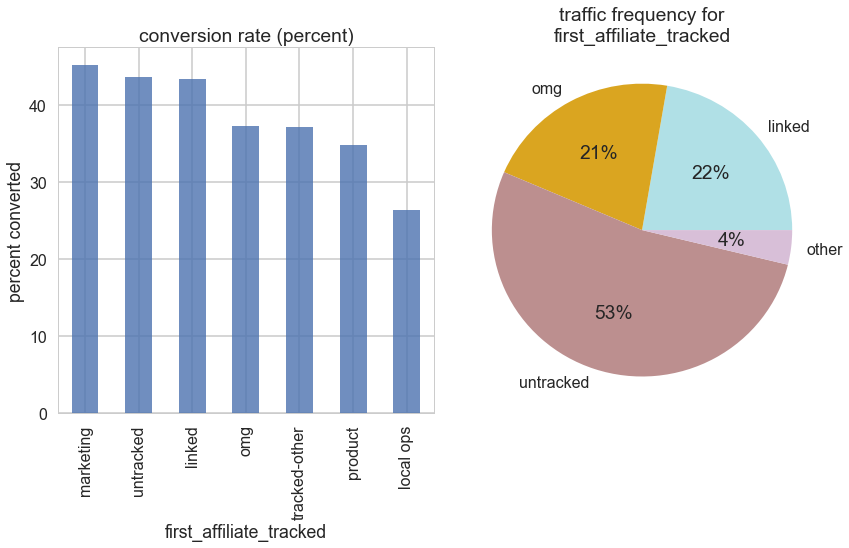

In [23]:
plot_conversion_rate('first_affiliate_tracked')

chi2 statistic for the conversion rate: 4619.56930139
p-value for the conversion rate: 0.0


signup_flow,3,6,2,10,8,21,0,15,24,12,25,23,16,1,20,5,4
traffic_freqency,8818.000000,300.000000,6874.000000,2.0,233.000000,196.000000,164611.000000,10.0,4322.000000,9317.000000,14651.000000,2835.000000,11.000000,1042.000000,14.000000,36.000000,1.0
conversion_rate,63.642549,54.333333,53.447774,50.0,45.064378,42.857143,42.407859,40.0,34.983804,32.778791,26.981093,22.680776,18.181818,15.834933,14.285714,5.555556,0.0


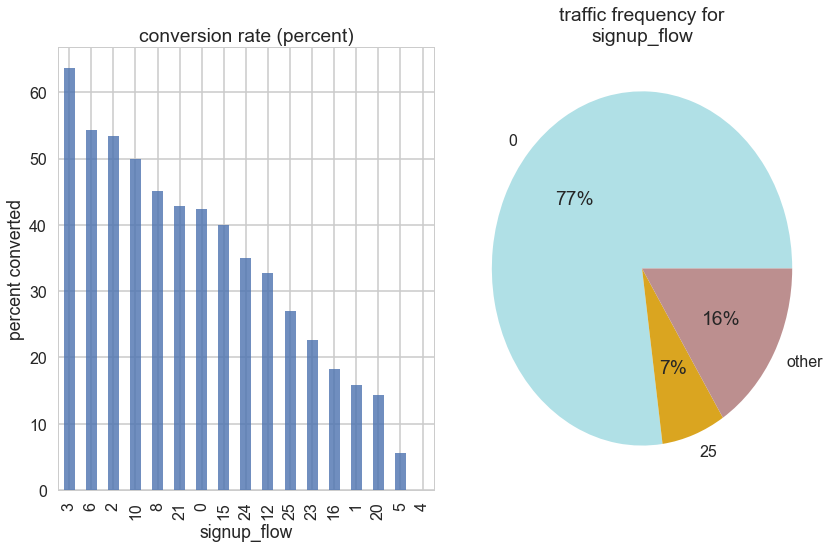

In [24]:
plot_conversion_rate('signup_flow')

chi2 statistic for the conversion rate: 383.125785914
p-value for the conversion rate: 2.1632178671e-66


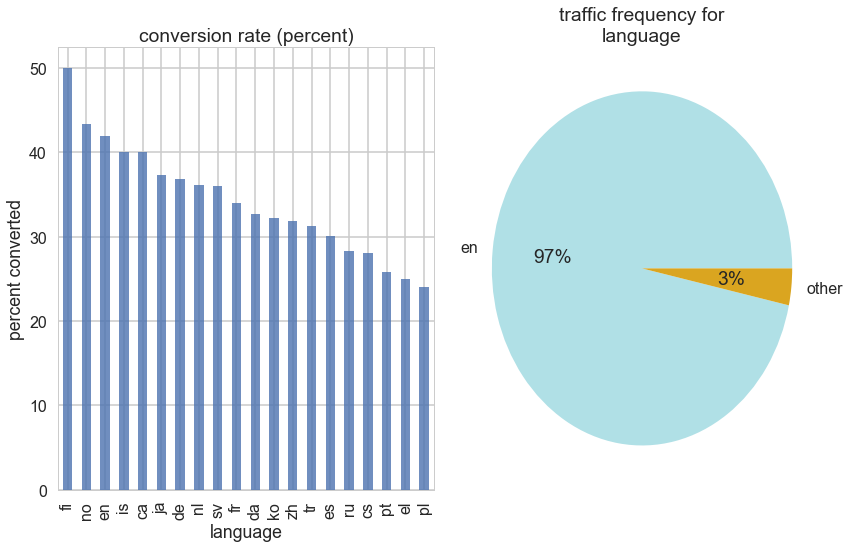

In [25]:
plot_conversion_rate('language')
None

<div class='alert alert-info'>
We see that 97% of the American users use English. All the other languages combined are used by 3% of the American users. 
</div>

chi2 statistic for the conversion rate: 1660.927864
p-value for the conversion rate: 0.0


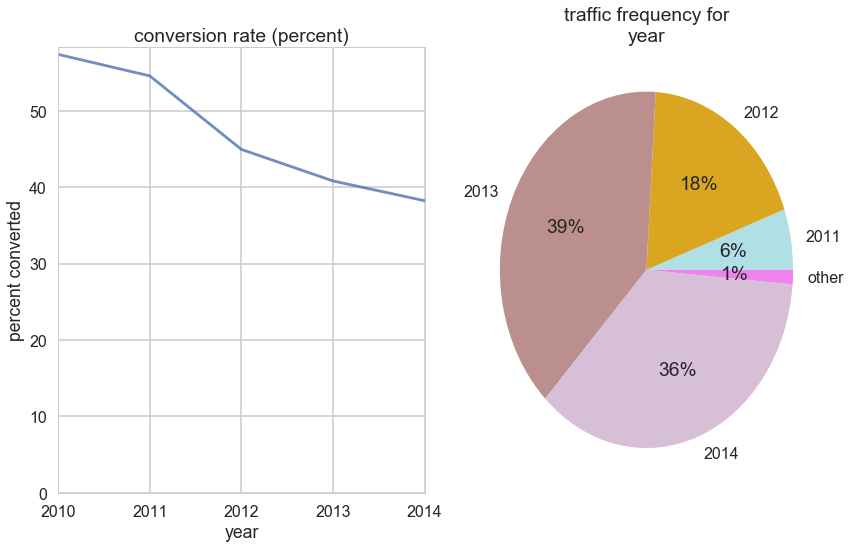

In [26]:
plot_conversion_rate('year', kind='line')
None

<div class='alert alert-info'>

It appears that the conversion rate is falling consistently. The model that targets hesitant users should help with improving the conversion rate. The number of people who create an account is going up. Keep in mind that the data from 2014 is only from the first half of 2014. 

</div>

chi2 statistic for the conversion rate: 3459.36220912
p-value for the conversion rate: 0.0


first_device_type,Mac Desktop,Desktop (Other),Windows Desktop,iPad,Android Tablet,SmartPhone (Other),iPhone,Other/Unknown,Android Phone
traffic_freqency,89512.000000,1198.000000,72670.000000,14329.000000,1289.00000,76.000000,20737.000000,10661.000000,2801.000000
conversion_rate,47.133345,45.826377,41.449016,38.076628,35.45384,32.894737,30.867531,26.939312,25.455195


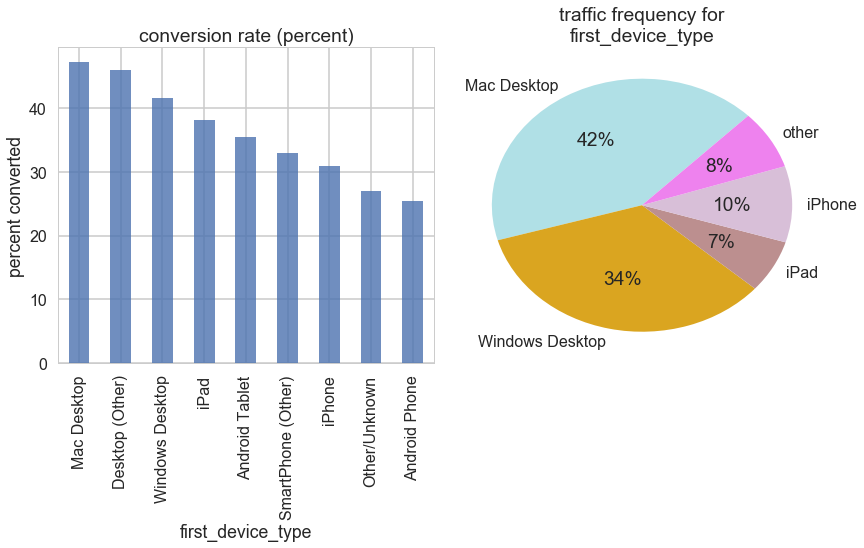

In [27]:
plot_conversion_rate('first_device_type',st=45)

<div class='alert alert-info'>

Bigger screens seem to correlate with higher conversion rate and smaller screens seem to correlate with lower conversion rates. This suggests that the mobile website interface or the mobile app is not as well designed as the desktop website. 

</div>

chi2 statistic for the conversion rate: 2559.54910439
p-value for the conversion rate: 0.0


signup_app,Web,Moweb,iOS,Android
traffic_freqency,182562.000000,6250.00,19008.000000,5453.000000
conversion_rate,43.773622,34.16,28.950968,22.593068


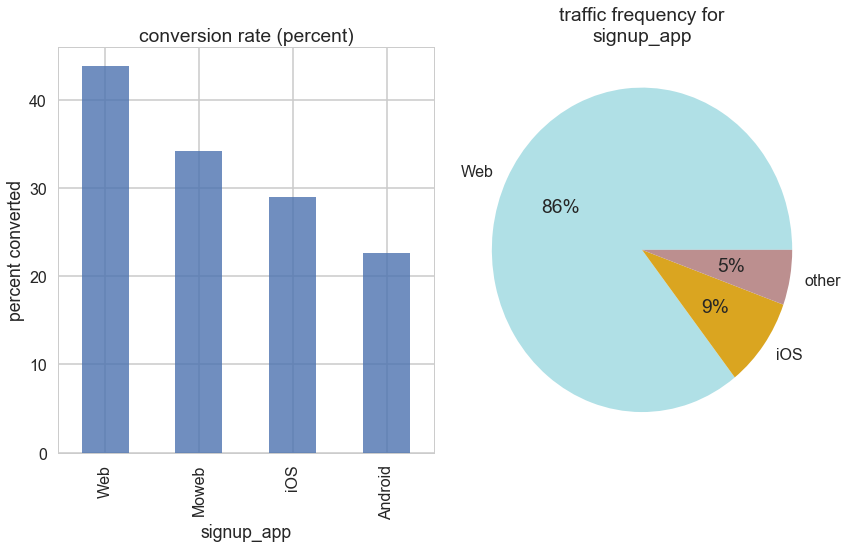

In [28]:
plot_conversion_rate('signup_app')

<div class='alert alert-info'>

Web is the best, but Moweb seems to be more effective in converting users compared to the standard iOS and Android apps. It would be a good idea to look at what Moweb is doing and use it to improve the iOS and Android apps. 

</div>

chi2 statistic for the conversion rate: nan
p-value for the conversion rate: nan


/Users/partha/anaconda2/lib/python2.7/site-packages/scipy/stats/contingency.py:242: RuntimeWarning: invalid value encountered in less
  if np.any(observed < 0):


affiliate_provider,craigslist,direct,google,other,bing,yahoo,facebook,naver,baidu,padmapper,vast,facebook-open-graph,yandex,email-marketing,meetup,gsp,wayn
traffic_freqency,3470.000000,137299.00000,51671.000000,12532.000000,2323.00000,496.000000,2270.000000,52.000000,29.000000,768.0000,829.000000,543.000000,17.000000,166.000000,346.000000,453.00000,8.0
conversion_rate,46.541787,43.07606,40.190823,37.097032,35.72966,35.080645,34.801762,34.615385,34.482759,32.8125,32.689988,25.782689,23.529412,22.289157,13.294798,8.16777,0.0


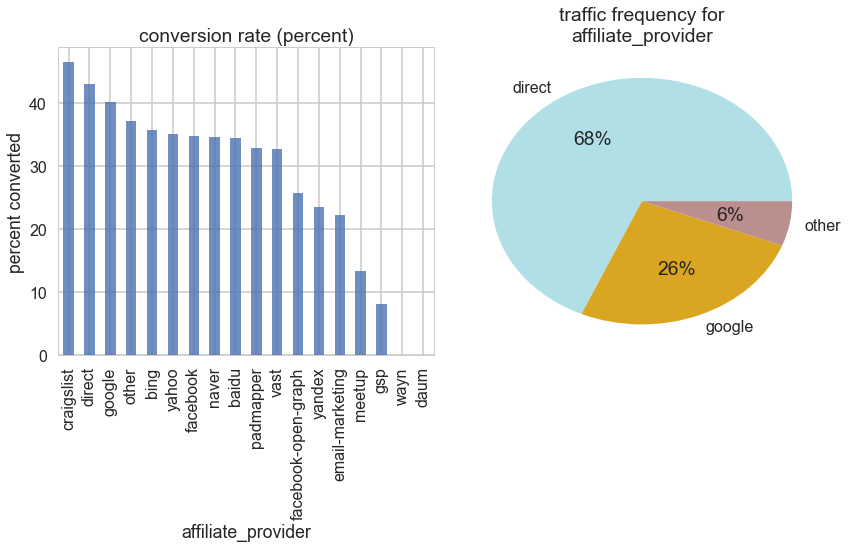

In [29]:
plot_conversion_rate('affiliate_provider')

chi2 statistic for the conversion rate: nan
p-value for the conversion rate: nan


first_browser,Camino,IceWeasel,Chromium,Iron,TenFourFox,SlimBrowser,Opera Mini,CoolNovo,wOSBrowser,RockMelt,...,Outlook 2007,PS Vita browser,Google Earth,Epic,Crazy Browser,Conkeror,OmniWeb,Comodo Dragon,IceDragon,Flock
traffic_freqency,9.000000,13.000000,73.00000,17.000000,8.0,2.0,4.0,6.0,6.0,23.000000,...,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0
conversion_rate,77.777778,61.538462,58.90411,52.941176,50.0,50.0,50.0,50.0,50.0,47.826087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


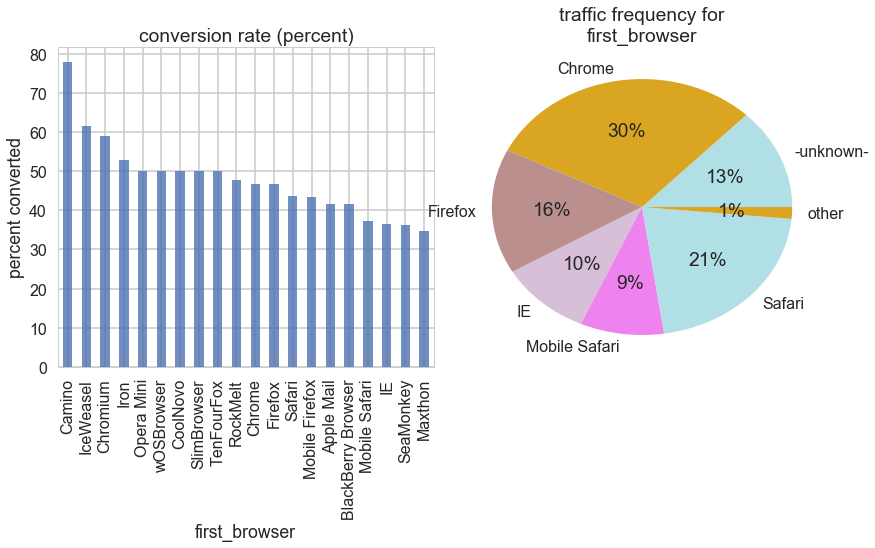

In [30]:
plot_conversion_rate('first_browser')

In [31]:
train_users.columns

Index([u'id', u'date_account_created', u'timestamp_first_active',
       u'date_first_booking', u'gender', u'age', u'signup_method',
       u'signup_flow', u'language', u'affiliate_channel',
       u'affiliate_provider', u'first_affiliate_tracked', u'signup_app',
       u'first_device_type', u'first_browser', u'country_destination',
       u'age_bucket', u'year', u'quarter', u'month', u'dayofweek', u'hour'],
      dtype='object')

# Seasonal patterns

In [32]:
def plot_monthly_traffic(country):
    df = train_users[train_users.country_destination == country]
    df = df.groupby(df.date_first_booking.dt.month).size()
    df.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    df.plot(kind='bar', figsize=(8,6))
    plt.title('distribution by month for ' + country)
    plt.xlabel('month')
    plt.ylabel('bookings')
    print 'one way chi squared statistic :', chisquare(df.values)[0]
    print 'p value :', chisquare(df.values)[1]
    return pd.DataFrame(df, columns=['traffic_frequency']).T

one way chi squared statistic : 2337.91351325
p value : 0.0


,January,February,March,April,May,June,July,August,September,October,November,December
traffic_frequency,4786,4753,5809,6012,6905,7054,5059,4953,4697,4559,3868,3832


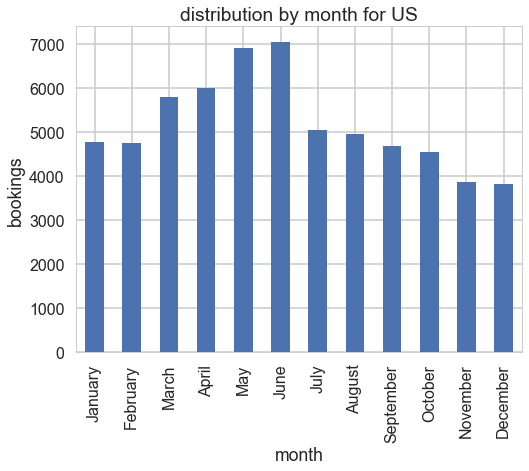

In [33]:
plot_monthly_traffic('US')

<div class='alert alert-info'>

Users who travel within the USA seem to like traveling in the spring/summer and prefer not to travel in the winter, as expected, because of the weather patterns. 

</div>

one way chi squared statistic : 33.2713754647
p value : 0.000475436873475


,January,February,March,April,May,June,July,August,September,October,November,December
traffic_frequency,59,48,48,27,55,36,31,31,41,50,63,49


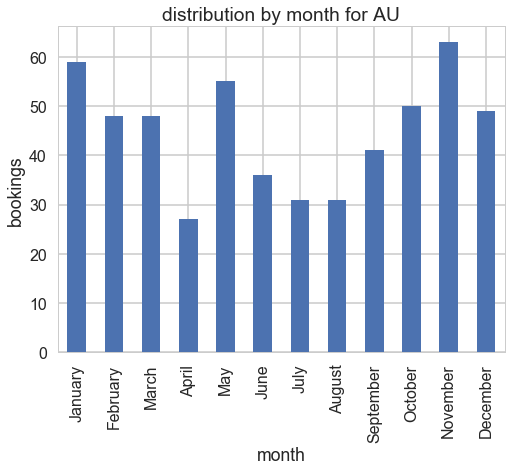

In [34]:
plot_monthly_traffic('AU')

<div class='alert alert-info'>

Users who travel to Australia seem to prefer to go there when it's warm there. The spike in May may be explained by the summer breaks of schools and colleges. 

</div>

one way chi squared statistic : 307.185263158
p value : 2.68043373146e-59


,January,February,March,April,May,June,July,August,September,October,November,December
traffic_frequency,53,72,103,162,214,219,145,144,102,72,76,63


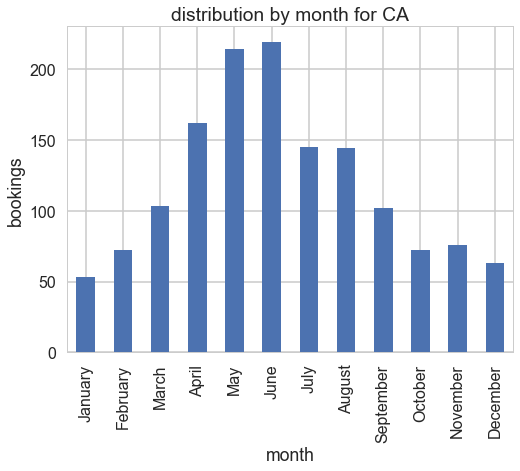

In [35]:
plot_monthly_traffic('CA')

<div class='alert alert-info'>

Users who travel to Canada really don't like to go there in winter. Summer weather is much better. 

</div>

<div class='alert alert-info'>

In general, those who travel to a European country tend to go there in May/June. As an example, we plot the traffic distribution for France: 
</div>

one way chi squared statistic : 639.58936043
p value : 4.72208597259e-130


,January,February,March,April,May,June,July,August,September,October,November,December
traffic_frequency,334,395,512,558,728,619,357,413,346,300,241,216


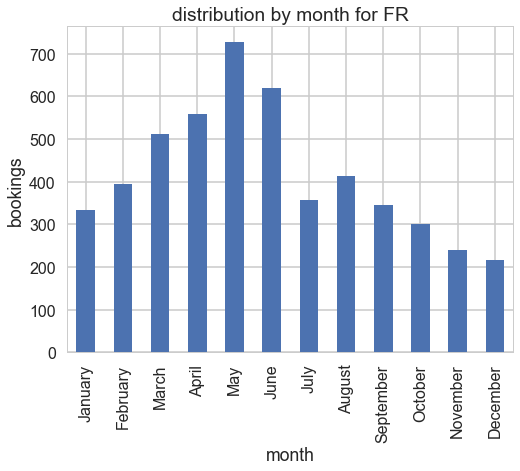

In [36]:
plot_monthly_traffic('FR')

<div class='alert alert-info'>

<p>People like to travel to a destination when it is warm there!</p>

<p><b>Action item: Offer promotions in winter. People are likely to book in the summer anyway, so charging more in summer may be a good way to increase revenue.</b> </p>
</div>

In [37]:
def plot_daily_traffic(country):
    df = train_users[train_users.country_destination == country]
    df = df.groupby(df.date_first_booking.dt.dayofweek).size()
    df.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df.plot(kind='bar', figsize=(8,6))
    plt.title('distribution by weekday for ' + country)
    plt.xlabel('weekday')
    plt.ylabel('bookings')
    print 'one way chi squared statistic :', chisquare(df.values)[0]
    print 'p value :', chisquare(df.values)[1]
    return pd.DataFrame(df, columns=['traffic_frequency']).T

# Weekly patterns in the booking

one way chi squared statistic : 1384.75781463
p value : 4.83696925044e-296


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
traffic_frequency,8741,10091,10127,9891,9569,7260,6608


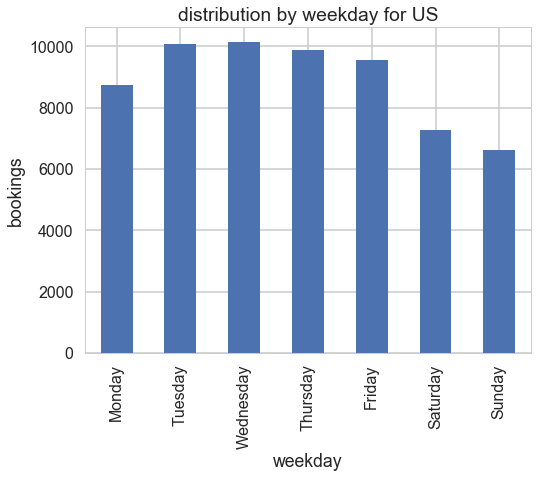

In [38]:
plot_daily_traffic('US')

<div class='alert alert-info'>

<p>The majority of bookings happen Tuesdays-Fridays. </p>
<p><b>Action item: Offer promotions or discounts on the weekends and hike the prices up on weekdays.</b></p>

</div>

<div class='alert alert-info'>

<p>Similar patterns for bookings in other countries. We plot the daily traffic for 'GB' as an example. </p>

</div>

one way chi squared statistic : 21.5589123867
p value : 0.00145505980592


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
traffic_frequency,327,354,364,372,325,288,287


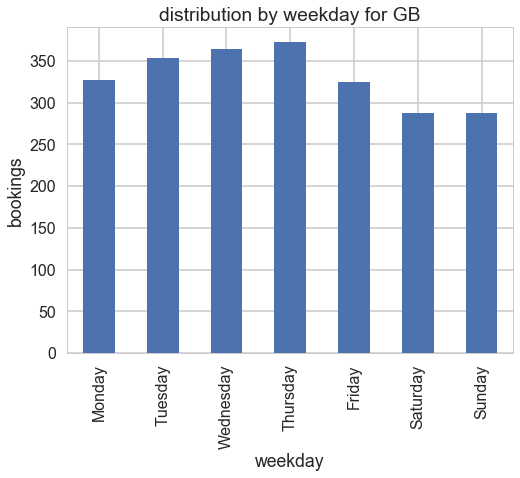

In [39]:
plot_daily_traffic('GB')

# The sessions table

In [40]:
# import the sessions table

sessions = pd.read_csv('csvdata/sessions.csv')
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [41]:
# combine the three action columns into one 
# total_action may be more meaningful compared to 
# the three action columns separately

sessions['total_action'] = sessions.action.str.lower() + ' then ' + sessions.action_type.str.upper() + ' then ' + sessions.action_detail.str.lower()

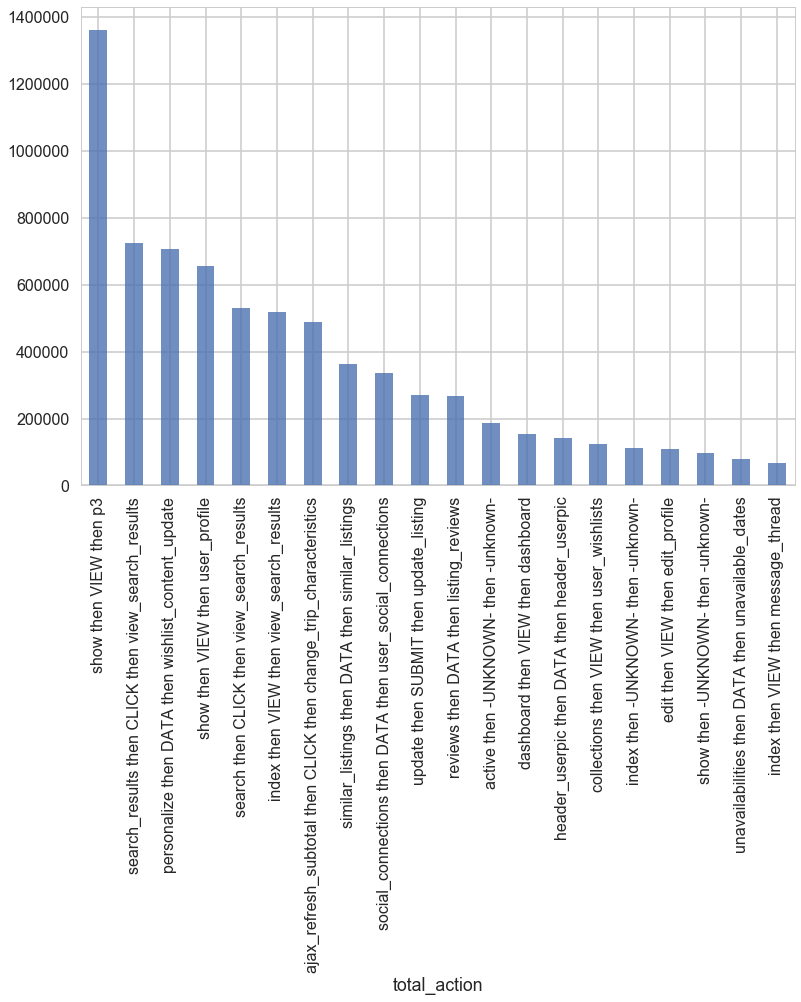

In [42]:
sessions.groupby('total_action').size().sort_values(ascending=False)[:20].plot(kind='bar', alpha=0.8)

<div class='alert alert-info'>
Most prominent user activities are related to searching, clicking and viewing the search results. 
</div>

In [43]:
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
total_action     1205830
dtype: int64

<div class='alert alert-info'>
A large number of values are missing from the `sessions` table. This indicates that something is wrong with data collection. 
</div>

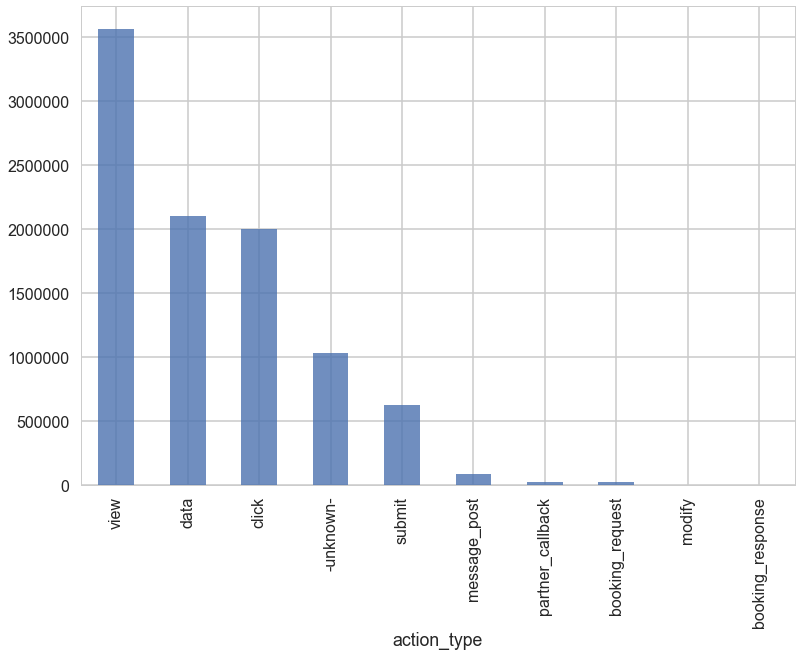

In [44]:
sessions.groupby('action_type').size().sort_values(ascending=False).plot(kind='bar', alpha=0.8)

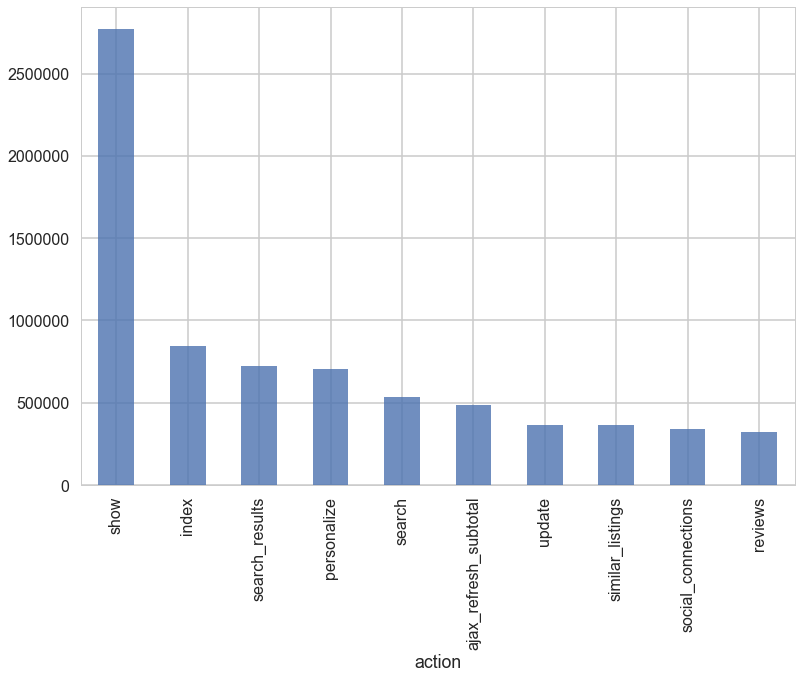

In [45]:
sessions.groupby('action').size().sort_values(ascending=False)[:10].plot(kind='bar', alpha=0.8)

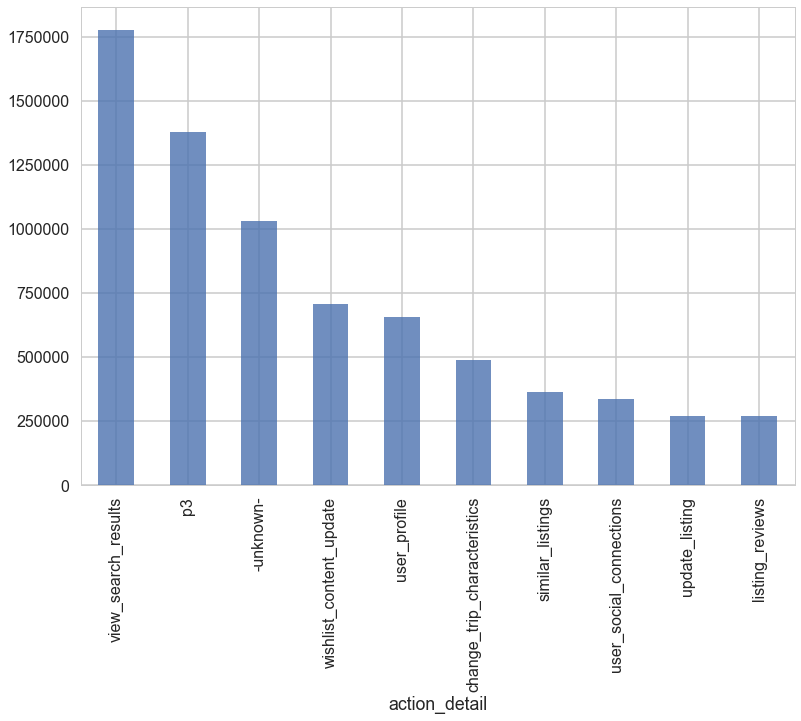

In [46]:
sessions.groupby('action_detail').size().sort_values(ascending=False)[:10].plot(kind='bar', alpha=0.8)

In [47]:
train_users = train_users.set_index('id')
s = sessions.groupby(['user_id']).agg(np.max).secs_elapsed / 86400.0
train_users['total_days_spent'] = train_users.join(s, how='inner').secs_elapsed.fillna(0.0)

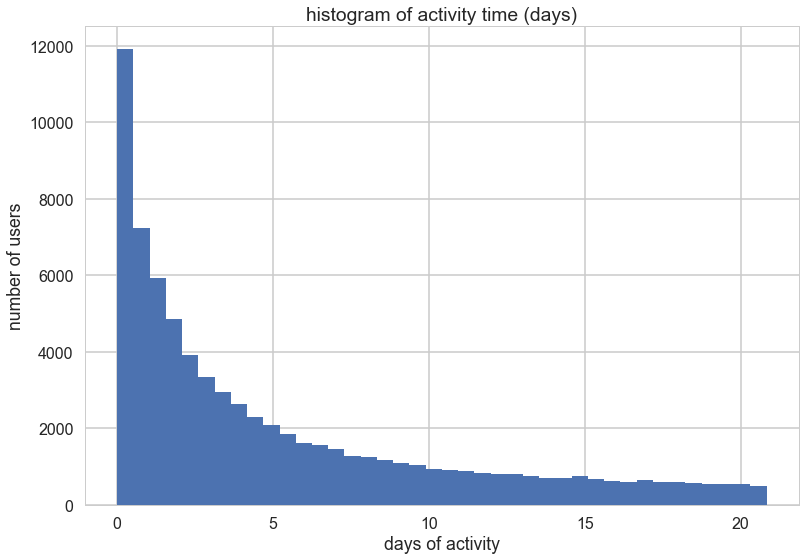

In [48]:
train_users[train_users.year == 2014].total_days_spent.hist(bins=40)
plt.xlabel('days of activity')
plt.ylabel('number of users')
plt.title('histogram of activity time (days)')

<div class='alert alert-info'> 

We observe that user activity drops fast the day after the user creates an account. 

</div>

/Users/partha/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


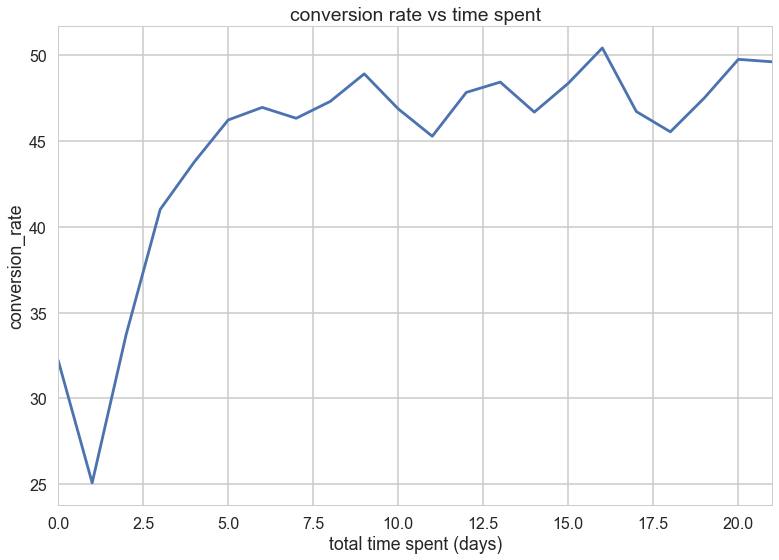

In [49]:
df = train_users[train_users.year == 2014]
df.total_days_spent = np.ceil(df.total_days_spent)
newdf = df.groupby([df.total_days_spent, df.date_first_booking.notnull()]).size().unstack().fillna(0.0)
rates = newdf[True] * 100. / (newdf[False] + newdf[True])
rates.plot()
plt.ylabel('conversion_rate')
plt.xlabel('total time spent (days)')
plt.title('conversion rate vs time spent')
None

<div class='alert alert-info'> 

<p> The conversion rate goes up for those users who spend at least five days browsing after they create an account. </p>

<p> <b>Action item</b>: Email users twice or thrice in the first week after they create an account to get them to spend more time on the website. </p>
</div>